In [1]:
import pandas                  as     pd
import missingno               as     msno
import seaborn                 as     sns
import matplotlib.pyplot       as     plt
import statsmodels.api         as     sm
import scipy.stats             as     stats
import numpy                   as     np
from   sklearn.linear_model    import LinearRegression
from   sklearn.metrics         import mean_squared_error, r2_score
from   sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Data Wrangling

In [2]:
# Import dataset into Pandas DataFrame
df_raw    = pd.read_csv("../dat/ship_data.csv")
n_records = df_raw.shape[0]

# Check column names and data types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 26 columns):
Time                                                          16248 non-null int64
Main Engine Fuel Consumption (MT/day)                         16085 non-null float64
Main Engine Using HFO (bool)                                  16085 non-null float64
Main Engine Using MGO (bool)                                  16085 non-null float64
Draft Forward (meters)                                        16085 non-null float64
Draft Aft (meters)                                            16085 non-null float64
Draft Mid-1 (meters)                                          16085 non-null float64
Draft Mid-2 (meters)                                          16085 non-null float64
Shaft Speed (RPM)                                             16085 non-null float64
Shaft Torque (kNm)                                            16085 non-null float64
Shaft Power (kW)                           

In [3]:
# Create helper sublists of column names
cols_main  = df_raw.columns[0:4]
cols_draft = df_raw.columns[4:8]
cols_shaft = df_raw.columns[8:11]
cols_speed = df_raw.columns[11:15]
cols_wind  = df_raw.columns[15:19]
cols_sea   = df_raw.columns[19:23]
cols_wave  = df_raw.columns[23:26]
df_raw.shape

(16248, 26)

# Missing Records

Time                                                            0
Main Engine Fuel Consumption (MT/day)                         163
Main Engine Using HFO (bool)                                  163
Main Engine Using MGO (bool)                                  163
Draft Forward (meters)                                        163
Draft Aft (meters)                                            163
Draft Mid-1 (meters)                                          163
Draft Mid-2 (meters)                                          163
Shaft Speed (RPM)                                             163
Shaft Torque (kNm)                                            163
Shaft Power (kW)                                              163
Speed Over Ground (knots)                                     163
Speed Through Water (knots)                                   163
Heading (degrees)                                               8
Rudder Angle (degrees)                                        163
Weather Se

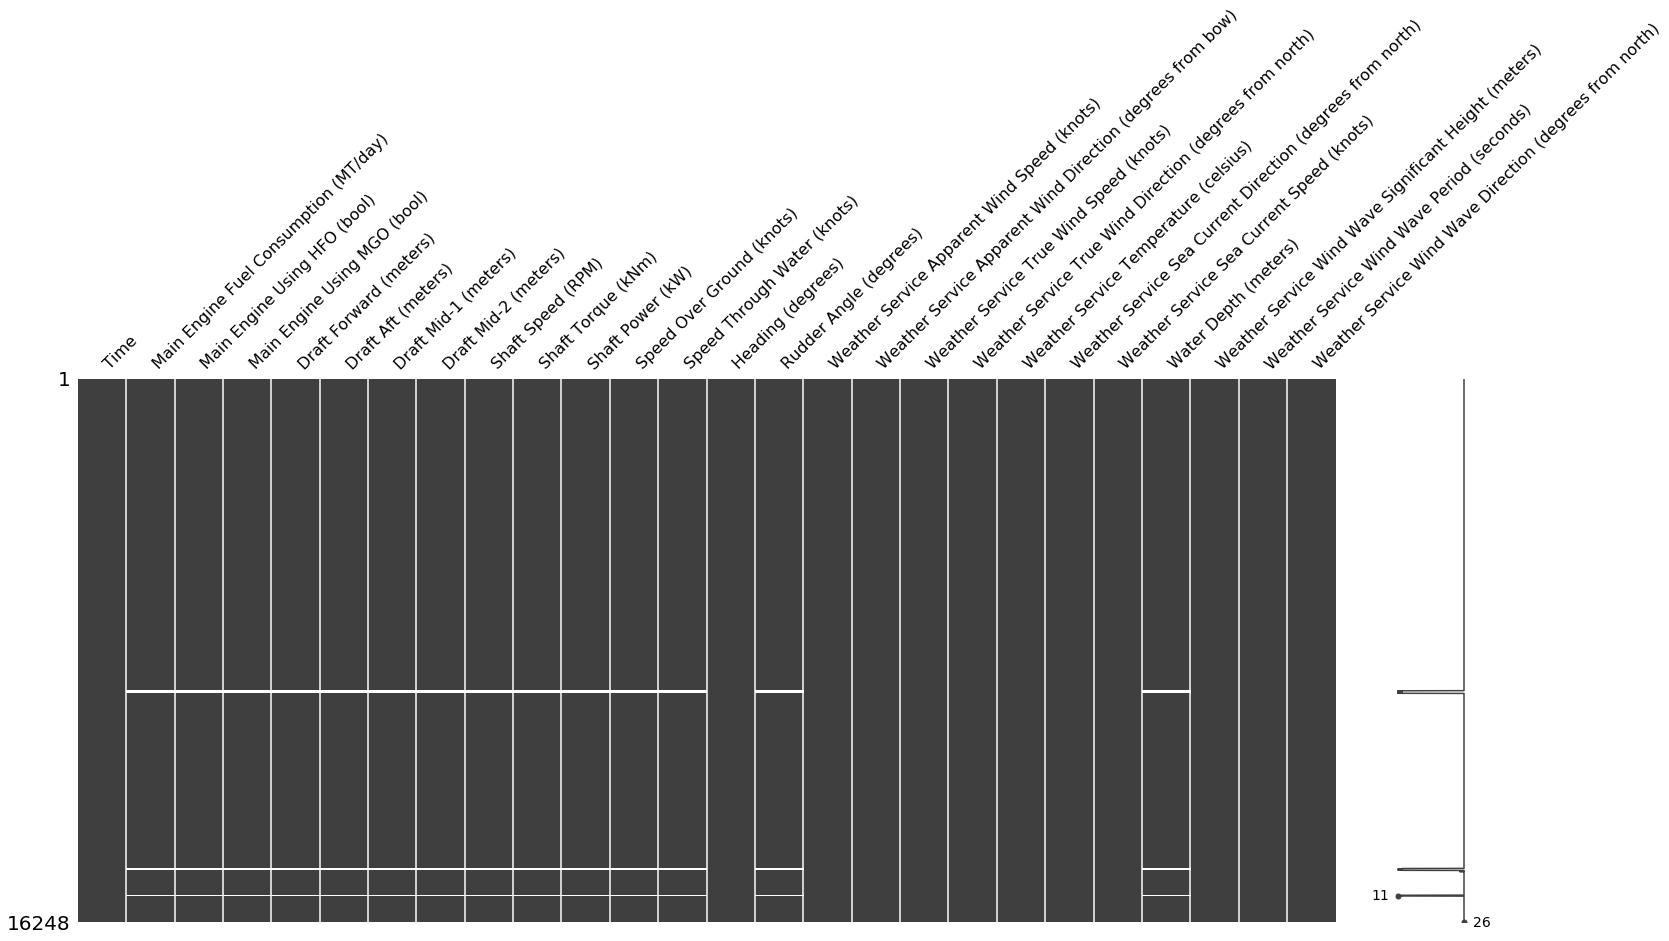

In [4]:
# Check missing values
print(df_raw.isnull().sum())
msno.matrix(df_raw)

Percentage of missing records:    1.0093549975381588
Percentage of remaining records:  98.99064500246185


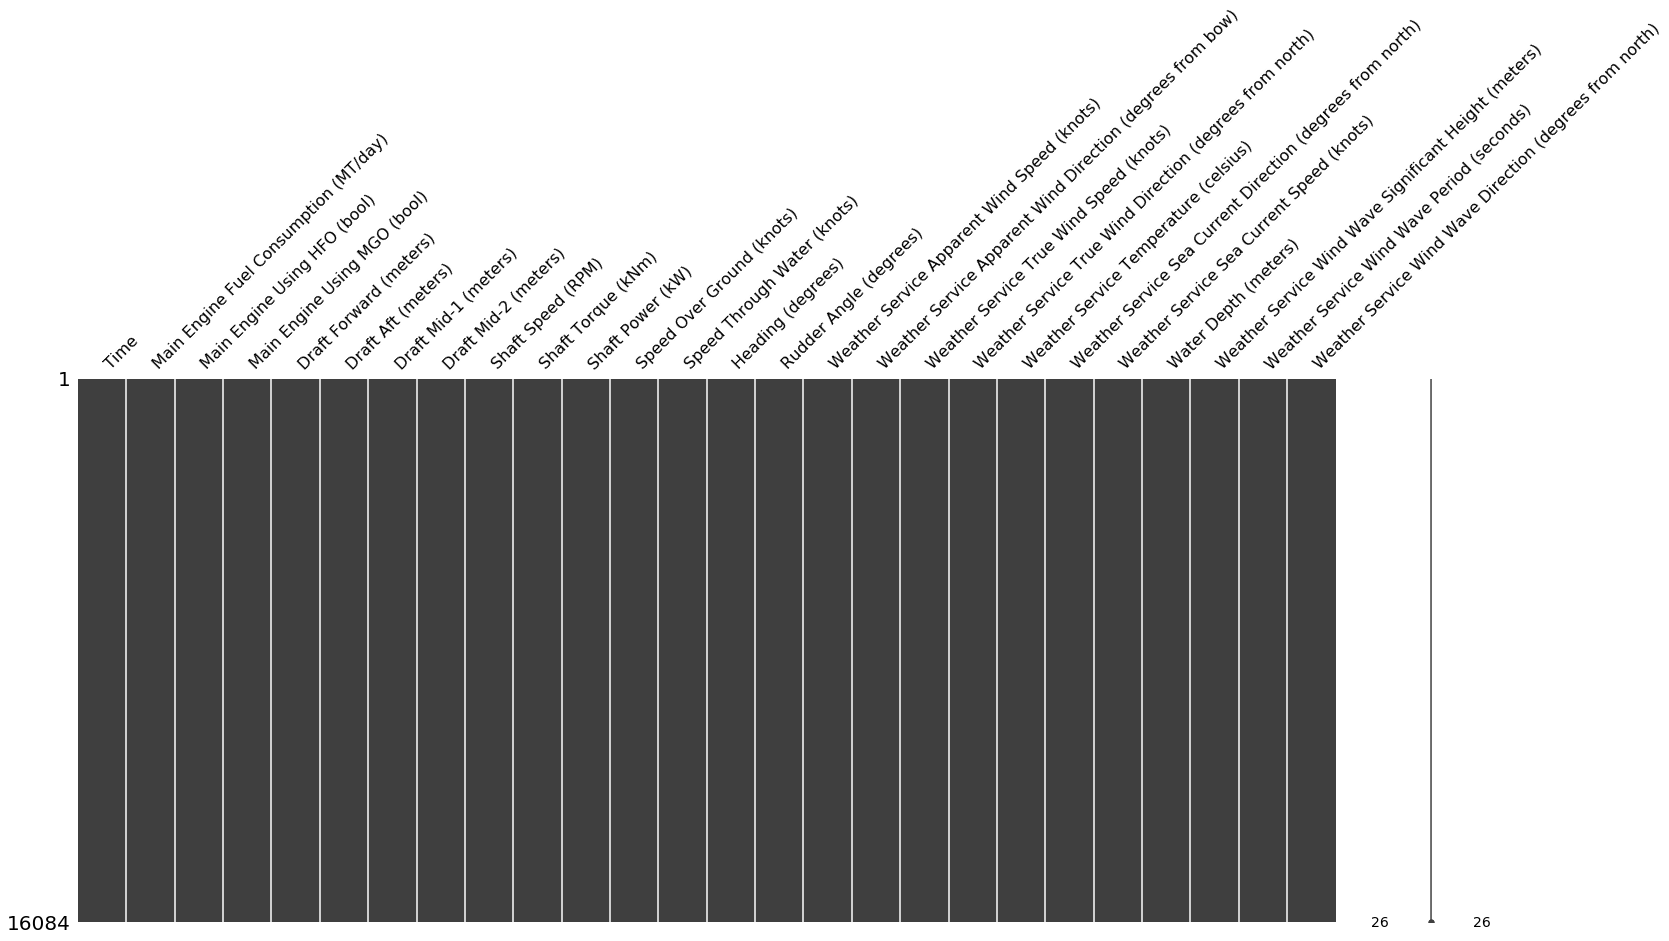

In [5]:
# Drop rows with missing target (Main Engine Fuel Consumption) ~ 1% of records
df_mod = df_raw.copy().dropna()
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of missing records:   ', ((1 - df_mod.shape[0] / n_records) * 100))
print('Percentage of remaining records: ', ((    df_mod.shape[0] / n_records) * 100))
msno.matrix(df_mod)

# Time Series Visualization

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b8fd160>,
      dtype=object)

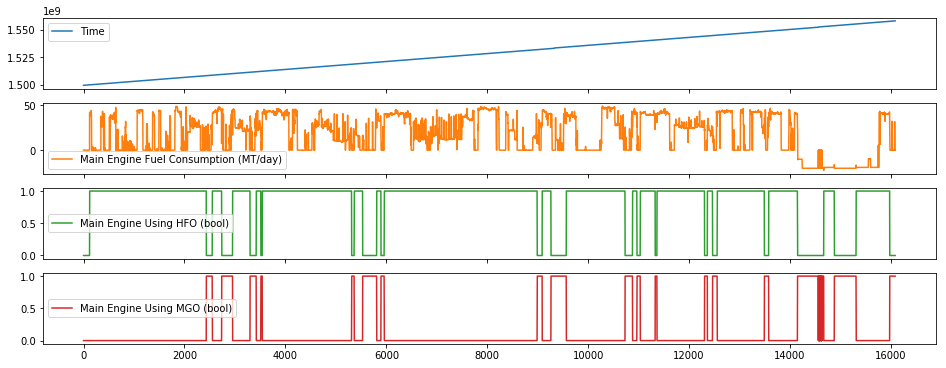

In [6]:
# Time and main engine
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

In [7]:
# Draft sensors
fig_draft, axes_draft = plt.subplots(len(cols_draft),1, figsize=(16,len(cols_draft)*1.5), sharex=True)
df_mod[cols_draft].plot(subplots=True, ax=axes_draft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d2b9cf8>,
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1afbab70>,
      dtype=object)

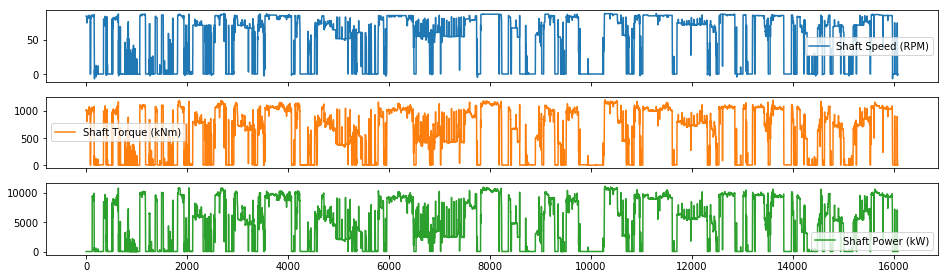

In [8]:
# Shaft performance
fig_shaft, axes_shaft = plt.subplots(len(cols_shaft),1, figsize=(16,len(cols_shaft)*1.5), sharex=True)
df_mod[cols_shaft].plot(subplots=True, ax=axes_shaft)

In [9]:
# Vessel speed
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e0679b0>,
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e067d30>,
      dtype=object)

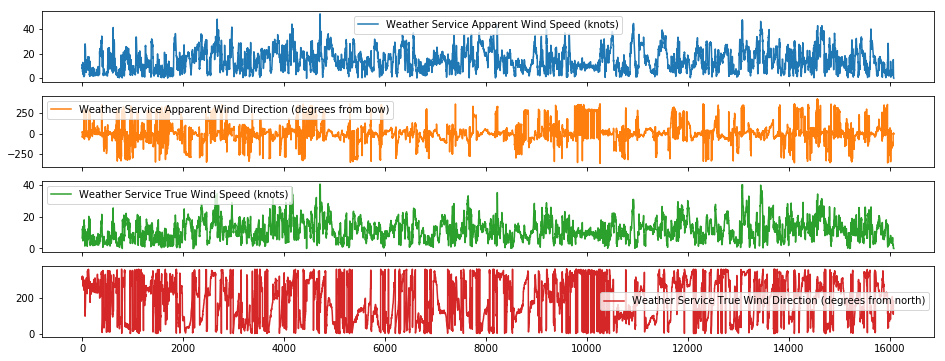

In [10]:
# Wind conditions
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f36b358>,
      dtype=object)

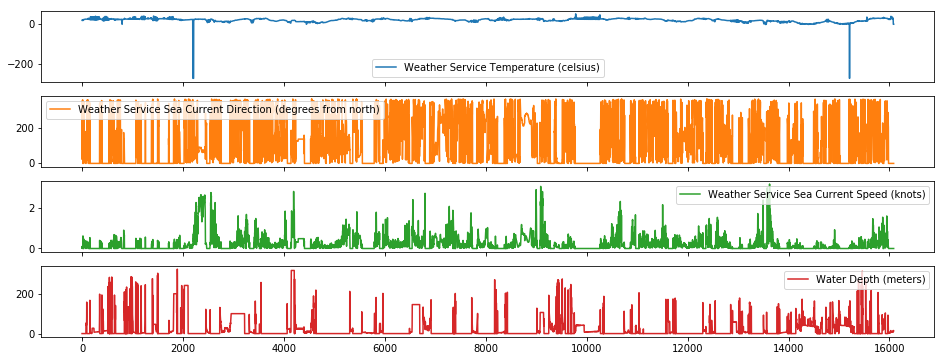

In [11]:
# Sea conditions
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

(16084, 23)

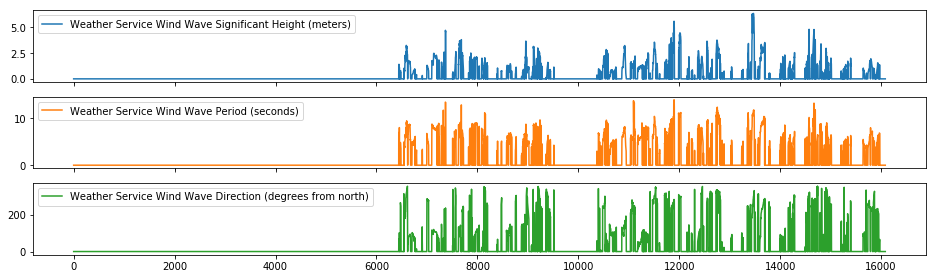

In [12]:
# Wave conditions
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

# Drop wave columns (too many missing records)
df_mod = df_mod.drop(cols_wave,axis=1)
df_mod.shape

# Data Cleaning

In [13]:
# Convert Unix time to datetime format
df_mod['Time'] = pd.to_datetime(df_mod['Time'], unit='s')
print(df_mod['Time'].head())

0   2017-07-06 13:15:00
1   2017-07-06 14:00:00
2   2017-07-06 15:00:00
3   2017-07-06 16:00:00
4   2017-07-06 17:00:00
Name: Time, dtype: datetime64[ns]


In [14]:
# Calibrate fuel consumption with most frequent near-zero measurement (-0.048 MT/day)
print(df_mod[cols_main[1]].value_counts().head())
df_mod[cols_main[1]] -= df_mod[cols_main[1]].value_counts().index[0]

# Drop records with negative fuel consumption ~ 16.2% of records
cutoff = 0.0
print('Percentage of records with negative consumption: ',
      df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:                 ', ((df_mod.shape[0] / n_records) * 100))

-0.048000     2105
-20.193103     829
-19.200000     617
-0.050483      526
 0.000000      149
Name: Main Engine Fuel Consumption (MT/day), dtype: int64
Percentage of records with negative consumption:  16.235844411619894
Percentage of remaining records:                  82.75480059084195


In [15]:
# Revert HFO and MGO to booleans (few partial-use records)
print(df_mod[cols_main[2]].value_counts())
df_mod[cols_main[2]] = df_mod[cols_main[2]].round(0).astype('int64')
df_mod[cols_main[3]] = df_mod[cols_main[3]].round(0).astype('int64')

# Check that only one fuel gauge is indicated at a time 
df_mod['Fuel Gauge'] = df_mod[cols_main[2]] + df_mod[cols_main[3]]
print(df_mod['Fuel Gauge'].value_counts())

# Drop records with neither HFO nor MGO indicator ~ 0.9% of records
print('Percentage of records with no fuel indicator: ',
      df_mod[df_mod['Fuel Gauge'] == 0].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod['Fuel Gauge'] == 0].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:              ', ((df_mod.shape[0] / n_records) * 100))

# Drop fuel gauge
df_mod = df_mod.drop(['Fuel Gauge'], axis=1)

1.000000    12456
0.000000      961
0.583333        4
0.083333        3
0.250000        3
0.666667        3
0.750000        2
0.083333        2
0.500000        2
0.166667        2
0.916667        1
0.833333        1
0.416667        1
0.833333        1
0.333333        1
0.583333        1
0.416667        1
0.333333        1
Name: Main Engine Using HFO (bool), dtype: int64
1    13294
0      152
Name: Fuel Gauge, dtype: int64
Percentage of records with no fuel indicator:  0.9354997538158543
Percentage of remaining records:               81.8193008370261


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20448438>,
      dtype=object)

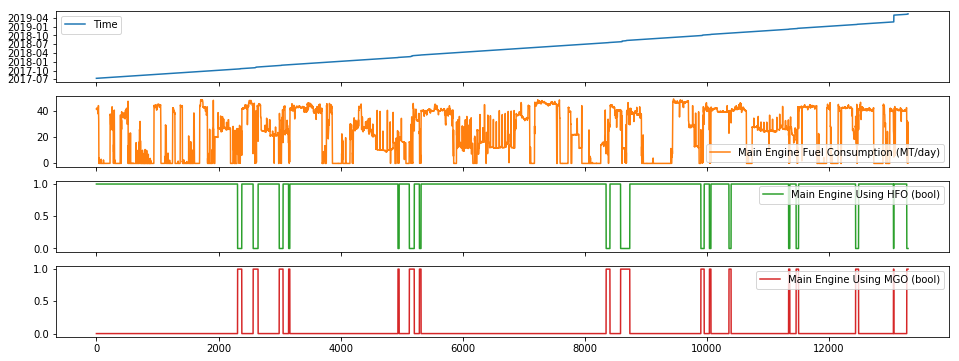

In [16]:
# Time and main engine (cleaned)
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

359.999195    1
359.998022    1
359.997018    1
359.996044    1
359.994729    1
Name: Rudder Angle (degrees), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c216ab908>],
      dtype=object)

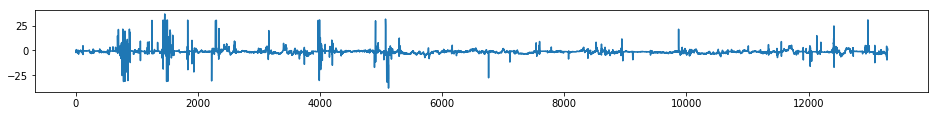

In [17]:
# Make rudder data continuous by using -180 to 180 degree angles
degrees = 360
print(df_mod[cols_speed[3]].value_counts().sort_index(ascending=False).head())
df_mod.loc[df_mod[cols_speed[3]] > 180, cols_speed[3]] -= degrees

# Rudder angle (cleaned)
fig_speed, axes_speed = plt.subplots(1,1, figsize=(16,1*1.5), sharex=True)
df_mod[cols_speed[3]].plot(subplots=True, ax=axes_speed)

-273.150000    18
-1.055194       1
 0.000000      17
 1.646941       1
 2.553591       1
Name: Weather Service Temperature (celsius), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21812550>],
      dtype=object)

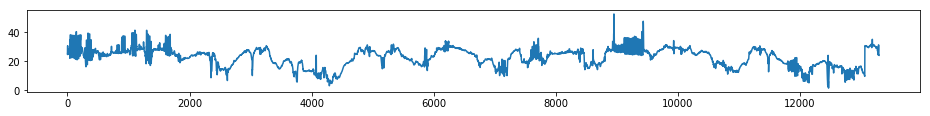

In [18]:
# Replace non-positive temperature records with median
print(df_mod[cols_sea[0]].value_counts().sort_index().head())
df_mod.loc[df_mod[cols_sea[0]] <= 0, cols_sea[0]] = df_mod[df_mod[cols_sea[0]] > 0][cols_sea[0]].median()

# Temperature (cleaned)
fig_sea, axes_sea = plt.subplots(1,1, figsize=(16,1*1.5), sharex=True)
df_mod[cols_sea[0]].plot(subplots=True, ax=axes_sea)

# Feature Engineering

In [19]:
# Engineer features for mean draft, trim (aft heavy) and list
df_mod['Draft Mean (meters)'] = df_mod[cols_draft].mean(axis=1)
df_mod['Trim (meters)']       = df_mod[cols_draft[1]] - df_mod[cols_draft[0]]
df_mod['List (meters)']       = df_mod[cols_draft[3]] - df_mod[cols_draft[2]]

# Plot time series
fig_draft, axes_draft = plt.subplots(3,1, figsize=(16,3*1.5), sharex=True)
df_mod[['Draft Mean (meters)',
        'Trim (meters)',
        'List (meters)']].plot(subplots=True, ax=axes_draft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c91e278>,
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21f2fc88>,
      dtype=object)

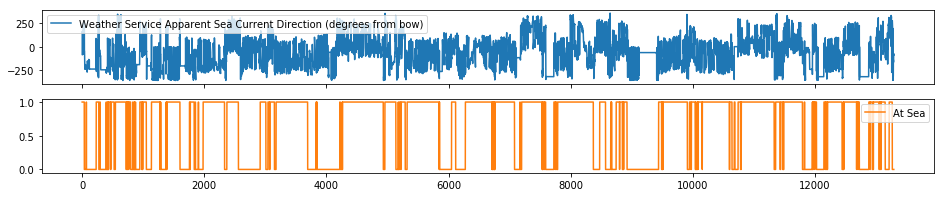

In [20]:
# Engineer features for apparent sea current direction and speed
col         = 'Weather Service Apparent Sea Current Direction (degrees from bow)'
df_mod[col] = df_mod[cols_sea[1]] - df_mod[cols_speed[2]]

# Engineer at-sea vs in-port from water depth
df_mod['At Sea'] = np.where(df_mod[cols_sea[3]]==0.0, 1, 0)

# Plot time series
fig_speed, axes_speed = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
df_mod[['Weather Service Apparent Sea Current Direction (degrees from bow)',
        'At Sea']].plot(subplots=True, ax=axes_speed)

# Exploratory Data Analysis

Main Engine Fuel Consumption (MT/day)                                1.000000
Shaft Power (kW)                                                     0.996606
Shaft Torque (kNm)                                                   0.988665
Shaft Speed (RPM)                                                    0.943000
Speed Through Water (knots)                                          0.927595
Speed Over Ground (knots)                                            0.927171
At Sea                                                               0.460948
Weather Service Apparent Wind Speed (knots)                          0.458996
Draft Aft (meters)                                                   0.421537
Weather Service Sea Current Direction (degrees from north)           0.404787
Draft Mean (meters)                                                  0.356758
Draft Mid-1 (meters)                                                 0.352593
Draft Mid-2 (meters)                                            

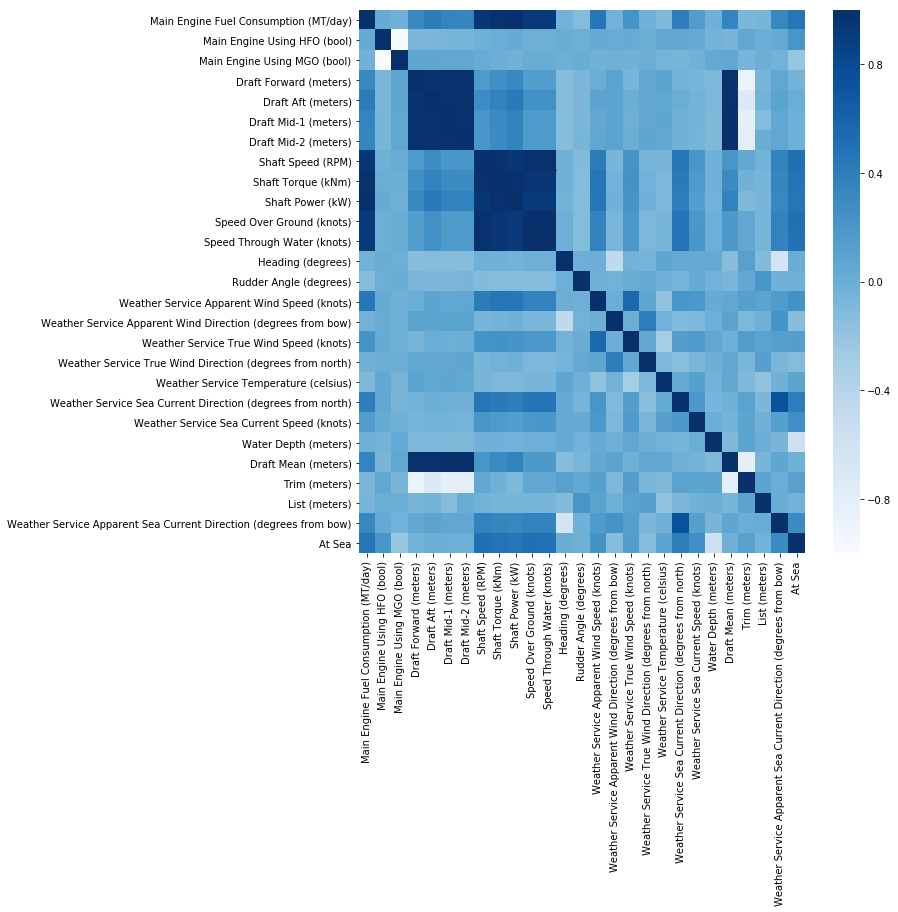

In [21]:
# Investigate multi-collinearity
fig = plt.figure(figsize=(10,10))
corr = df_mod.corr()
sns.heatmap(corr, cmap="Blues")

# Print correlation coefficients of dependent variables to target
corr[cols_main[1]].sort_values(ascending=False)

Main Engine Fuel Consumption (MT/day)  Main Engine Using HFO (bool)  \
count                           13294.000000                  13294.000000   
mean                               23.088197                      0.937942   
std                                17.431775                      0.241270   
min                                 0.000000                      0.000000   
25%                                 0.201277                      1.000000   
50%                                25.125368                      1.000000   
75%                                40.672698                      1.000000   
max                                49.138823                      1.000000   

       Main Engine Using MGO (bool)  
count                  13294.000000  
mean                       0.062058  
std                        0.241270  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        0.000000  
max                        1.000000

<Figure size 432x216 with 0 Axes>

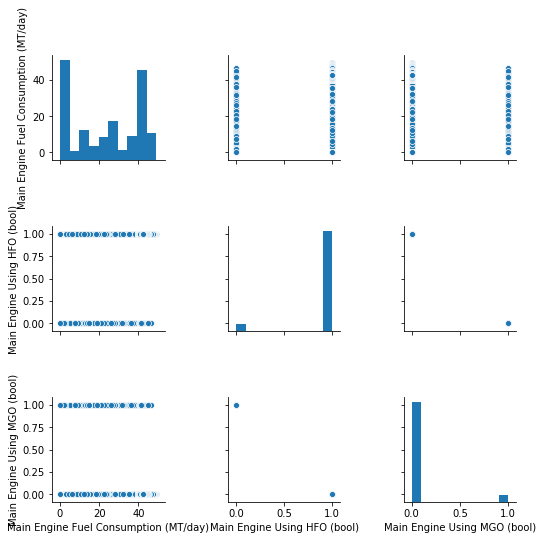

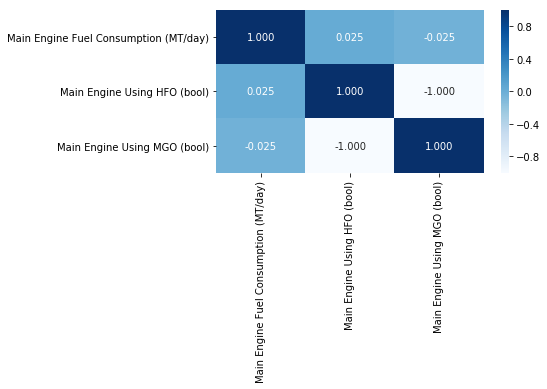

In [22]:
# Pair plots
fig = plt.figure(figsize=(6,3))
sns.pairplot(df_mod[cols_main])

# Investigate multi-collinearity of main sensors
fig       = plt.figure(figsize=(6,3))
corr_main = df_mod[cols_main].corr()
sns.heatmap(corr_main, annot=True, fmt=".3f", cmap="Blues")

# Time and main engine
df_mod[cols_main].describe()

Main Engine Fuel Consumption (MT/day)  \
Fuel                                                           
Main Engine Using HFO                              30.257497   
Main Engine Using MGO                              20.660725   

                       Main Engine Using HFO (bool)  \
Fuel                                                  
Main Engine Using HFO                             1   
Main Engine Using MGO                             0   

                       Main Engine Using MGO (bool)  
Fuel                                                 
Main Engine Using HFO                             0  
Main Engine Using MGO                             1

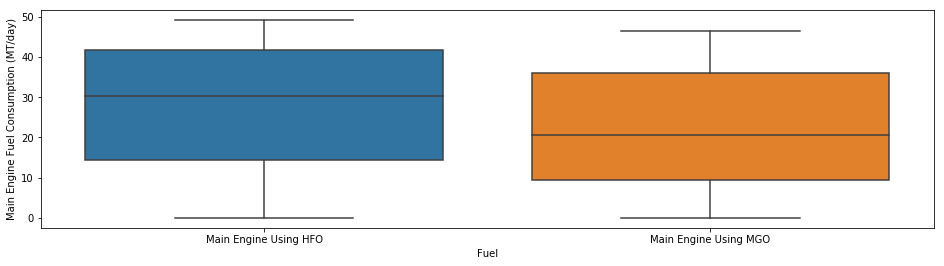

In [23]:
# Explore fuel consumption by fuel source
df_hfo = df_mod[df_mod[cols_main[2]] == 1].copy()
df_hfo['Fuel'] = 'Main Engine Using HFO'

df_mgo = df_mod[df_mod[cols_main[3]] == 1].copy()
df_mgo['Fuel'] = 'Main Engine Using MGO'

# Drop records with zero fuel consumption (for EDA only)
df_fuel = pd.concat([df_hfo, df_mgo])
df_fuel = df_fuel[df_fuel[cols_main[1]] > 0]

# Plot fuel consumption by fuel source
plt.figure('Fuel Source', figsize=(16,4))
sns.boxplot(x='Fuel', y=cols_main[1], data=df_fuel)

# Print median fuel consumption by fuel source
df_fuel.groupby('Fuel')[cols_main].median()

Draft Forward (meters)  Draft Aft (meters)  Draft Mid-1 (meters)  \
count            13294.000000        13294.000000          13294.000000   
mean                 7.998504            9.512124              8.751299   
std                  2.566563            1.727537              2.115794   
min                  1.761927            6.477834              5.264249   
25%                  5.761688            7.933613              6.811051   
50%                  6.851848            8.736326              7.675043   
75%                 10.754630           11.498797             11.165957   
max                 13.136587           12.589208             12.076237   

       Draft Mid-2 (meters)  
count          13294.000000  
mean               8.765571  
std                2.100942  
min                5.681231  
25%                6.836185  
50%                7.682327  
75%               11.170656  
max               12.127948

<Figure size 432x216 with 0 Axes>

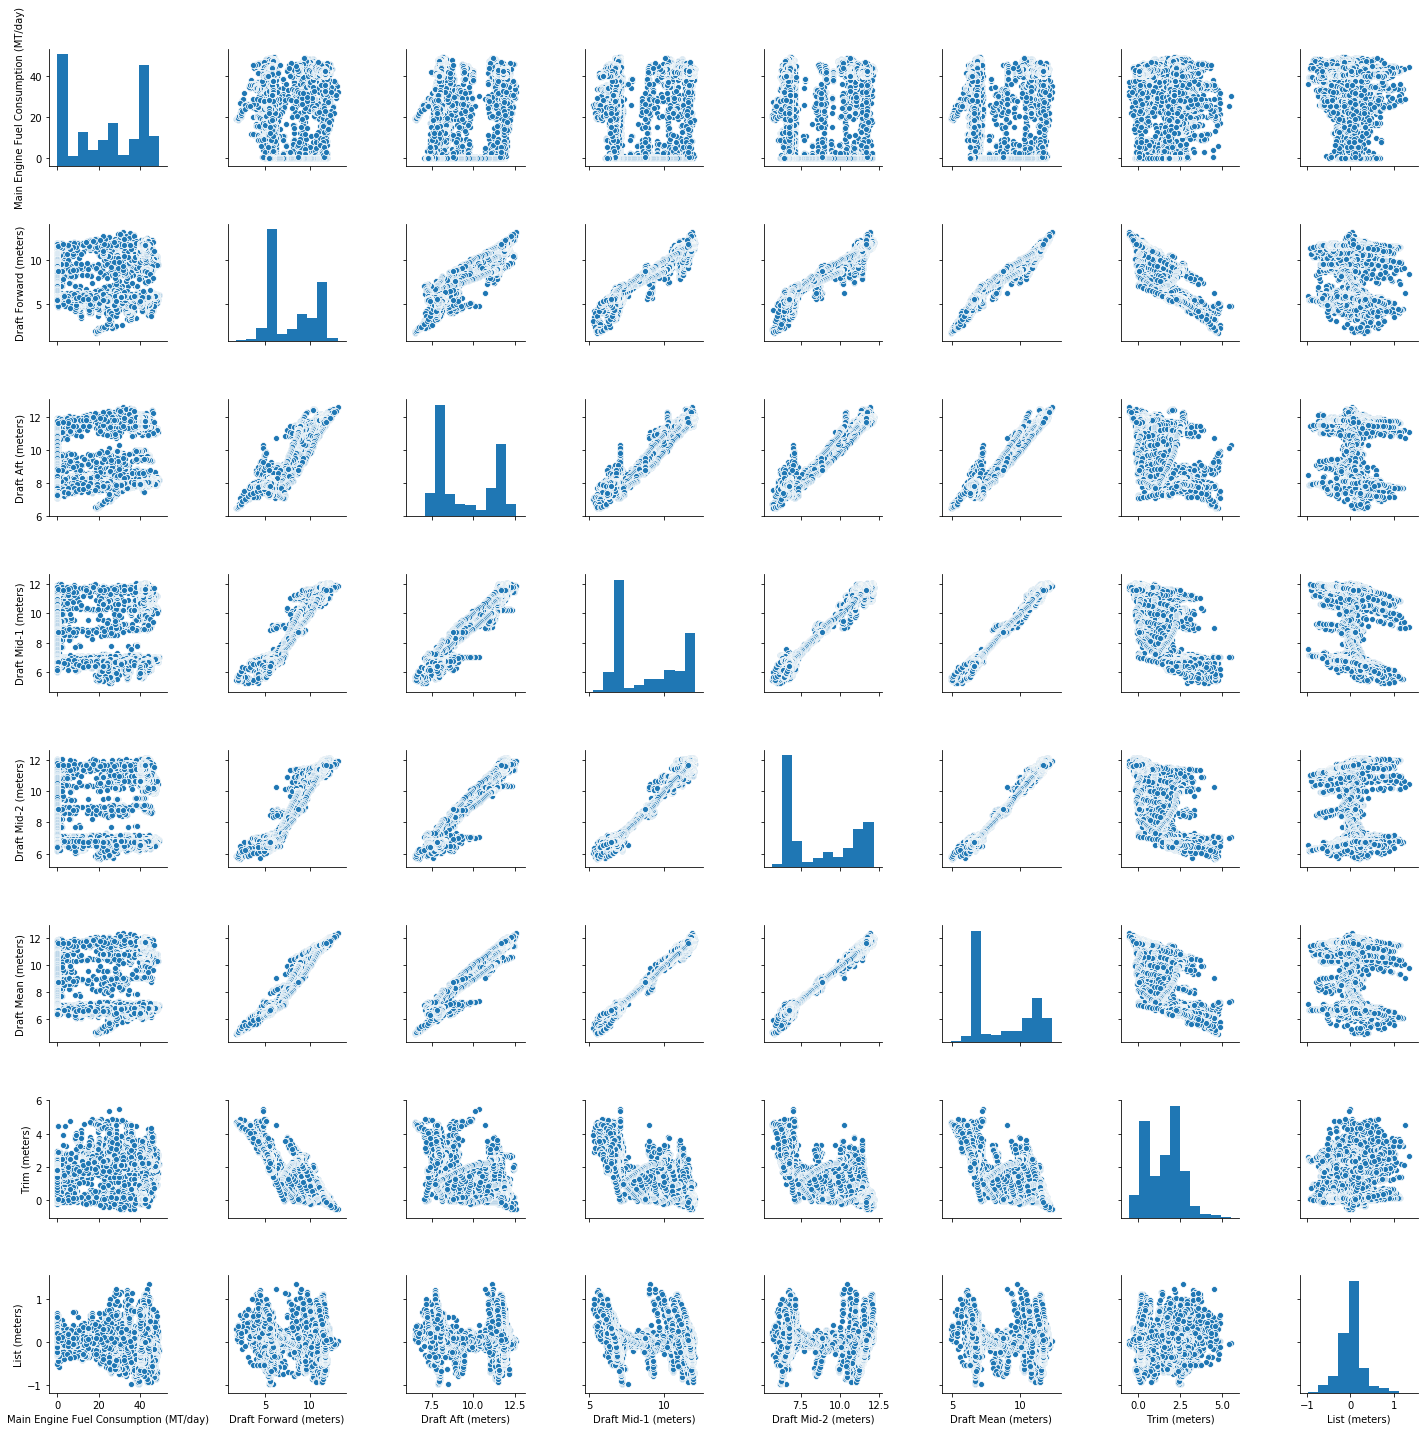

In [24]:
# Pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_draft) + ['Draft Mean (meters)','Trim (meters)','List (meters)']
sns.pairplot(df_mod[cols])

# Investigate multi-collinearity of draft sensors
fig        = plt.figure(figsize=(8,4))
corr_draft = df_mod[cols].corr()
sns.heatmap(corr_draft, annot=True, fmt=".3f", cmap="Blues")

# Draft sensors
df_mod[cols_draft].describe()

Shaft Speed (RPM)  Shaft Torque (kNm)  Shaft Power (kW)
count       13294.000000        13294.000000      13294.000000
mean           54.767804          621.972953       5179.079963
std            35.363715          435.562025       4004.406412
min            -7.110332           -0.000460          5.276229
25%             0.000000           12.027868          7.960926
50%            71.773562          745.846497       5630.125342
75%            85.696325         1038.392816       9315.960332
max            88.959431         1206.091541      11150.041983

<Figure size 432x216 with 0 Axes>

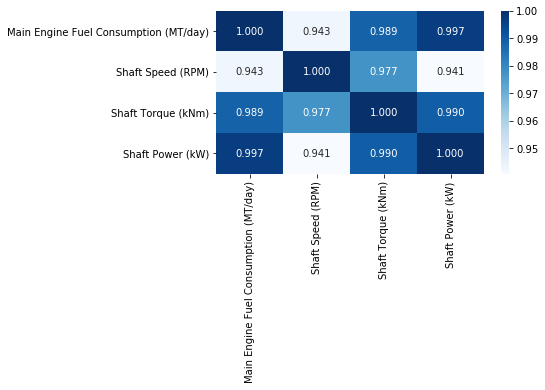

In [25]:
# Pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_shaft)
sns.pairplot(df_mod[cols])

# Investigate multi-collinearity of shaft sensors (Power = Speed x Torque x unit conversion)
fig        = plt.figure(figsize=(6,3))
corr_shaft = df_mod[cols].corr()
sns.heatmap(corr_shaft, annot=True, fmt=".3f", cmap="Blues")

# Shaft performance
df_mod[cols_shaft].describe()

Speed Over Ground (knots)  Speed Through Water (knots)  \
count               13294.000000                 13294.000000   
mean                   10.055001                     9.953996   
std                     6.314415                     6.320701   
min                     0.000000                    -0.812132   
25%                     1.807973                     1.325097   
50%                    13.044746                    13.059407   
75%                    15.263638                    15.232244   
max                    19.844884                    17.186902   

       Heading (degrees)  Rudder Angle (degrees)  
count       13294.000000            13294.000000  
mean          189.708437               -1.254819  
std           101.726415                3.393461  
min             0.123706              -37.916252  
25%            90.143655               -2.054992  
50%           225.322315               -1.242882  
75%           277.797905               -0.682076  
max           359.824424               36.801810

<Figure size 432x216 with 0 Axes>

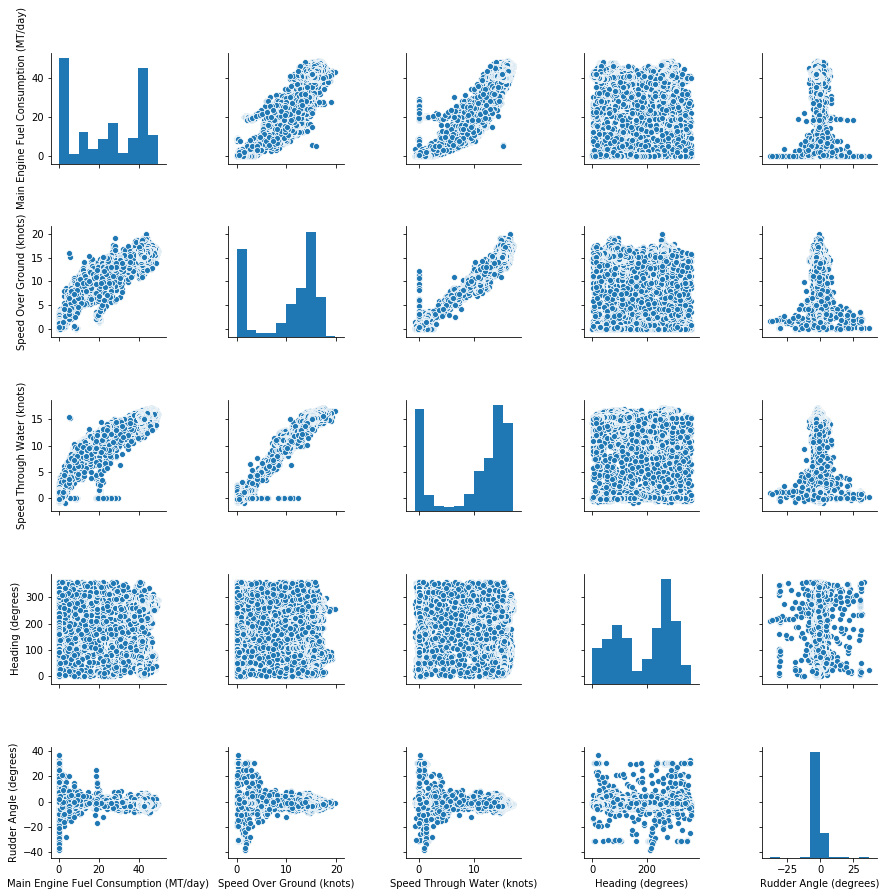

In [26]:
# Pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_speed)
sns.pairplot(df_mod[cols])

# Investigate multi-collinearity of speed and heading sensors
fig        = plt.figure(figsize=(6,3))
corr_speed = df_mod[cols].corr()
sns.heatmap(corr_speed, annot=True, fmt=".3f", cmap="Blues")

# Vessel speed
df_mod[cols_speed].describe()

In [27]:
# Investigate multi-collinearity of wind sensors
fig       = plt.figure(figsize=(6,3))
corr_wind = df_mod[cols].corr()
sns.heatmap(corr_wind, annot=True, fmt=".3f", cmap="Blues")

# Wind conditions
df_mod[cols_wind].describe()

Weather Service Apparent Wind Speed (knots)  \
count                                 13294.000000   
mean                                     15.038842   
std                                       8.649540   
min                                       0.000000   
25%                                       8.314335   
50%                                      13.822674   
75%                                      20.802552   
max                                      51.955335   

       Weather Service Apparent Wind Direction (degrees from bow)  \
count                                       13294.000000            
mean                                            1.773545            
std                                           113.749803            
min                                          -358.561592            
25%                                           -41.250026            
50%                                            -2.358334            
75%                                            35.728403            
max                                           358.000339            

       Weather Service True Wind Speed (knots)  \
count                             13294.000000   
mean                                 12.024931   
std                                   6.450350   
min                                   0.000000   
25%                                   7.314592   
50%                                  11.359357   
75%                                  15.994612   
max                                  40.845838   

       Weather Service True Wind Direction (degrees from north)  
count                                       13294.000000         
mean                                          188.159086         
std                                           114.740370         
min                                             0.000568         
25%                                            77.182397         
50%                                           201.647541         
75%                                           295.228736         
max                                           359.997076

Weather Service Temperature (celsius)  \
count                           13294.000000   
mean                               22.597054   
std                                 6.345735   
min                                 1.646941   
25%                                18.369530   
50%                                24.121217   
75%                                27.173381   
max                                52.559168   

       Weather Service Sea Current Direction (degrees from north)  \
count                                       13294.000000            
mean                                          125.063068            
std                                           116.041048            
min                                             0.000000            
25%                                             0.000000            
50%                                           101.412659            
75%                                           224.488252            
max                                           359.999716            

       Weather Service Sea Current Speed (knots)  Water Depth (meters)  
count                               13294.000000          13294.000000  
mean                                    0.292205             19.292376  
std                                     0.416830             47.640937  
min                                     0.000000              0.000000  
25%                                     0.000000              0.000000  
50%                                     0.159163              0.000000  
75%                                     0.382378              8.999632  
max                                     3.184603            326.803230

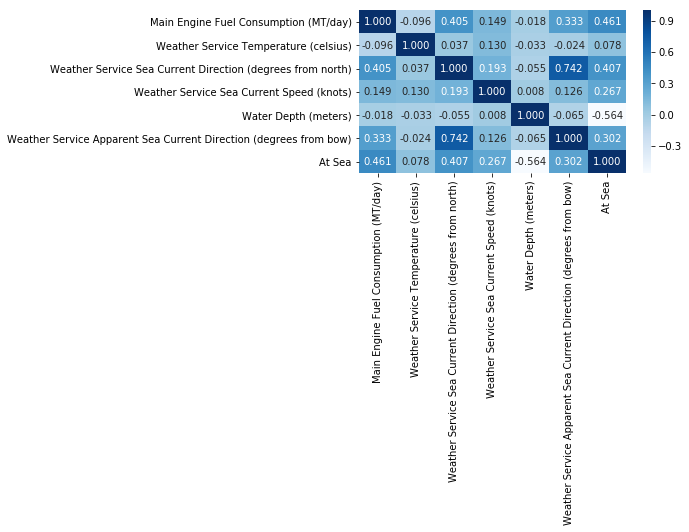

In [28]:
# Investigate multi-collinearity of sea sensors
fig      = plt.figure(figsize=(6,3))
cols     = [cols_main[1]] + list(cols_sea) + [
    'Weather Service Apparent Sea Current Direction (degrees from bow)','At Sea']
corr_sea = df_mod[cols].corr()
sns.heatmap(corr_sea, annot=True, fmt=".3f", cmap="Blues")

# Sea conditions
df_mod[cols_sea].describe()

# Outliers

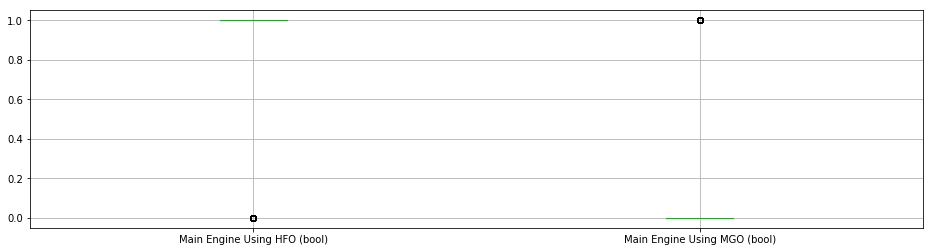

In [29]:
# Main engine fuel consumption
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_main[1]], ax=ax_box)
sns.distplot(df_mod[cols_main[1]], ax=ax_hist)

# Fuel source
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_main[2:4]].boxplot()

Percentage of low fuel consumption records:  0.0
Percentage of remaining records:             81.8193008370261


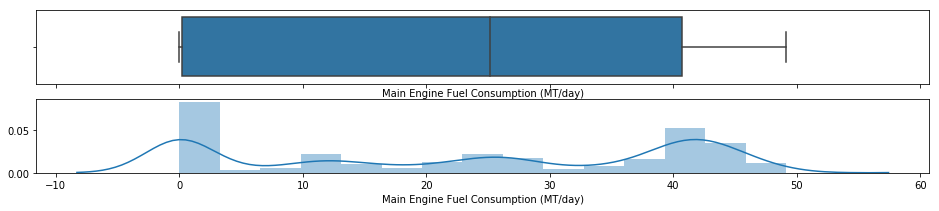

In [30]:
# Drop records with low fuel consumption (less than 5 MT/day) ~ 22.4% of records
cutoff = 0
print('Percentage of low fuel consumption records: ',
      df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:            ', ((df_mod.shape[0] / n_records) * 100))

# Main engine fuel consumption
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_main[1]], ax=ax_box)
sns.distplot(df_mod[cols_main[1]], ax=ax_hist)

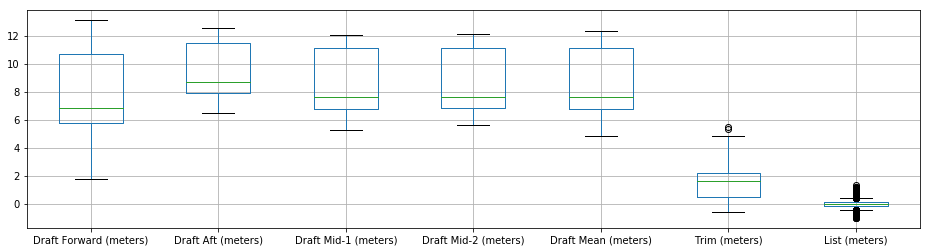

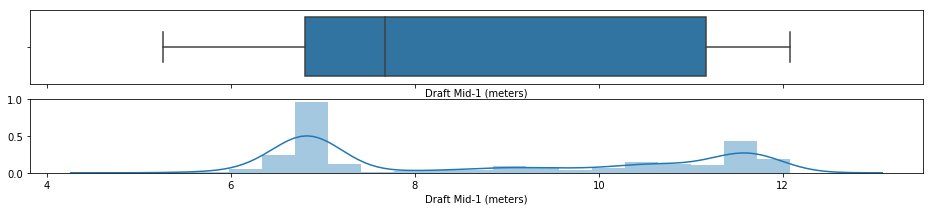

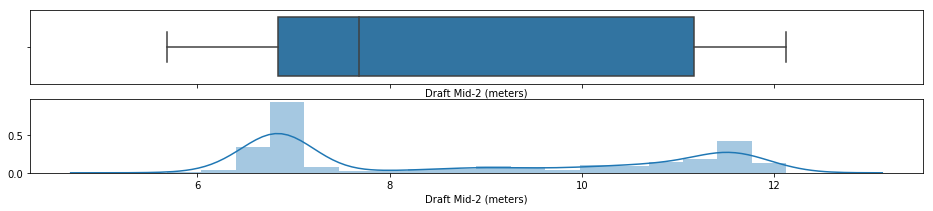

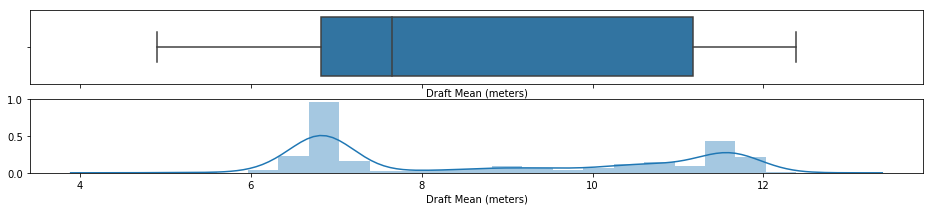

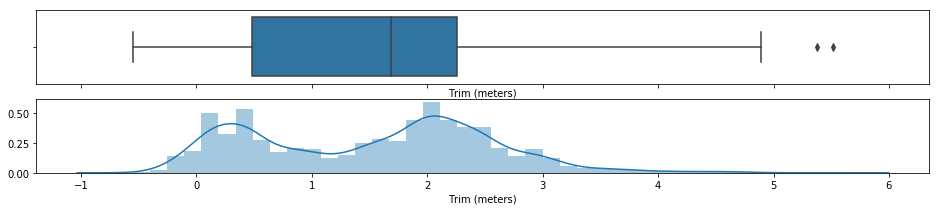

In [31]:
# Draft sensors
plt.figure("Boxplot", figsize=(16,4))
cols = list(cols_draft) + ['Draft Mean (meters)','Trim (meters)','List (meters)']
df_mod[cols].boxplot()

# Forward draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[0]], ax=ax_box)
sns.distplot(df_mod[cols_draft[0]], ax=ax_hist)

# Aft draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[1]], ax=ax_box)
sns.distplot(df_mod[cols_draft[1]], ax=ax_hist)

# Mid-1 draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[2]], ax=ax_box)
sns.distplot(df_mod[cols_draft[2]], ax=ax_hist)

# Mid-2 draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[3]], ax=ax_box)
sns.distplot(df_mod[cols_draft[3]], ax=ax_hist)

# Draft mean
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Draft Mean (meters)'], ax=ax_box)
sns.distplot(df_mod['Draft Mean (meters)'], ax=ax_hist)

# Trim
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Trim (meters)'], ax=ax_box)
sns.distplot(df_mod['Trim (meters)'], ax=ax_hist)

# List
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['List (meters)'], ax=ax_box)
sns.distplot(df_mod['List (meters)'], ax=ax_hist)

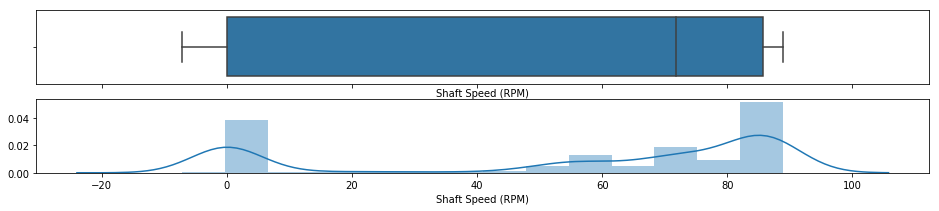

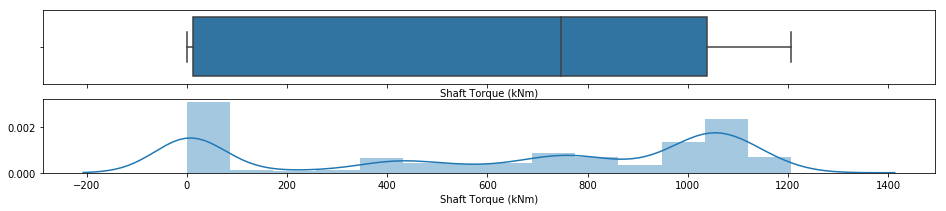

In [32]:
# Shaft speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[0]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[0]], ax=ax_hist)

# Shaft torque
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[1]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[1]], ax=ax_hist)

# Shaft power
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[2]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[2]], ax=ax_hist)

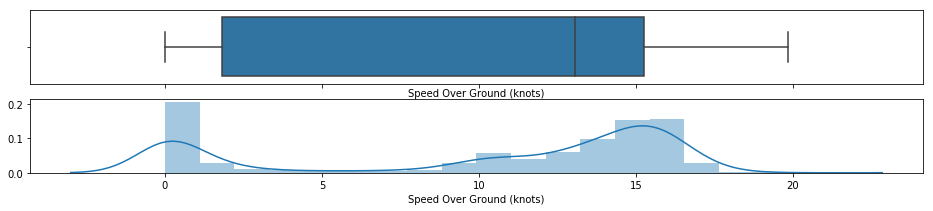

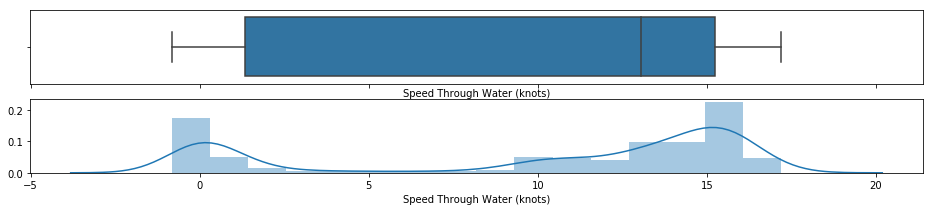

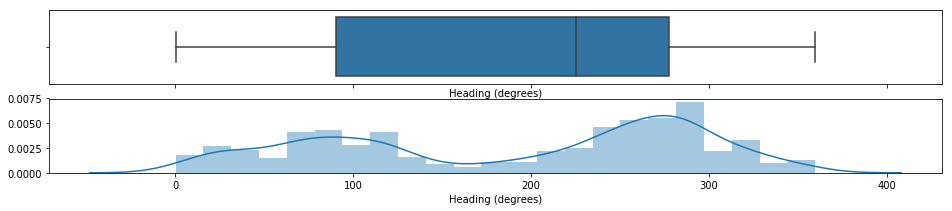

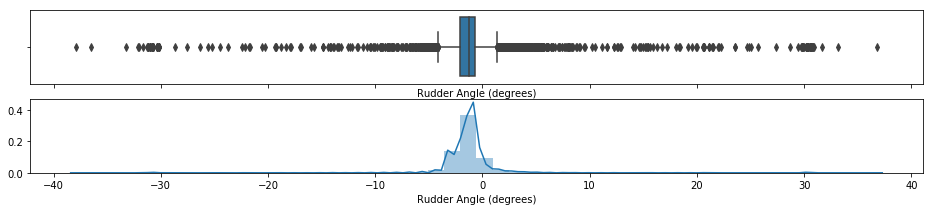

In [33]:
# Vessel speed
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_speed[0:2]].boxplot()

# Speed over ground
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[0]], ax=ax_box)
sns.distplot(df_mod[cols_speed[0]], ax=ax_hist)

# Speed through water
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[1]], ax=ax_box)
sns.distplot(df_mod[cols_speed[1]], ax=ax_hist)

# Heading angle
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[2]], ax=ax_box)
sns.distplot(df_mod[cols_speed[2]], ax=ax_hist)

# Rudder angle
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[3]], ax=ax_box)
sns.distplot(df_mod[cols_speed[3]], ax=ax_hist)

Percentage of low speed over ground records:   0.0
Percentage of high speed over ground records:  0.0
Percentage of remaining records:               81.8193008370261


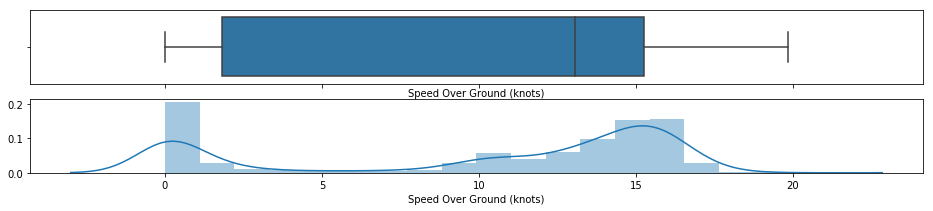

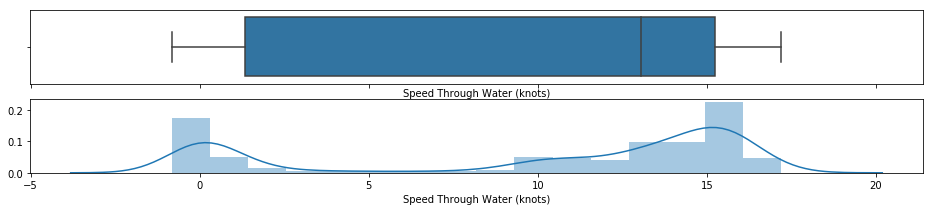

In [34]:
# Drop records with low speed over ground (less than 9 knots) ~ 1.2% of records
cutoff = 0
print('Percentage of low speed over ground records:  ',
      df_mod[df_mod[cols_speed[0]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_speed[0]] < cutoff].index)

# Drop records with high speed over ground (more than 18 knots) ~ 0.2% of records
cutoff = 50
print('Percentage of high speed over ground records: ',
      df_mod[df_mod[cols_speed[0]] > cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_speed[0]] > cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:              ', ((df_mod.shape[0] / n_records) * 100))

# Speed over ground
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[0]], ax=ax_box)
sns.distplot(df_mod[cols_speed[0]], ax=ax_hist)

# Speed through water
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[1]], ax=ax_box)
sns.distplot(df_mod[cols_speed[1]], ax=ax_hist)

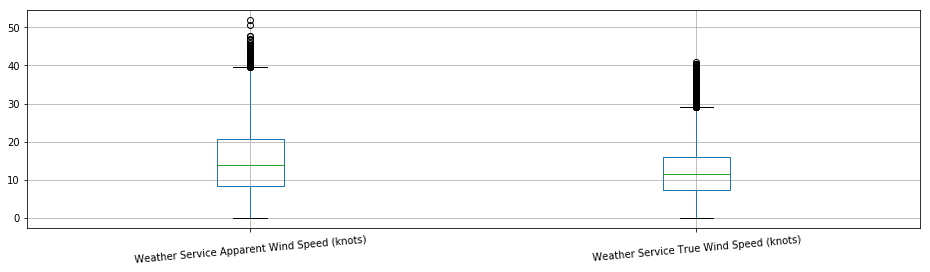

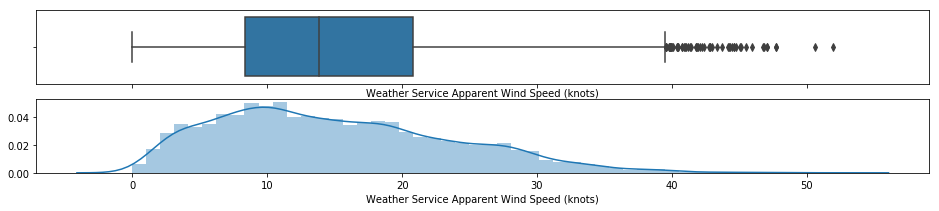

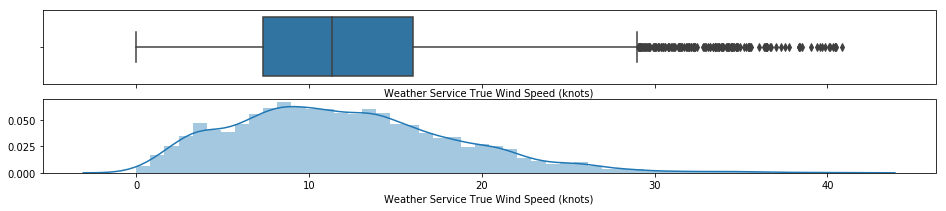

In [35]:
# Wind speed
plt.figure("Boxplot", figsize=(16,4))
df_mod[[cols_wind[0],cols_wind[2]]].boxplot()
plt.xticks(rotation=5)

# Apparent wind speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[0]], ax=ax_box)
sns.distplot(df_mod[cols_wind[0]], ax=ax_hist)

# True wind speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[2]], ax=ax_box)
sns.distplot(df_mod[cols_wind[2]], ax=ax_hist)

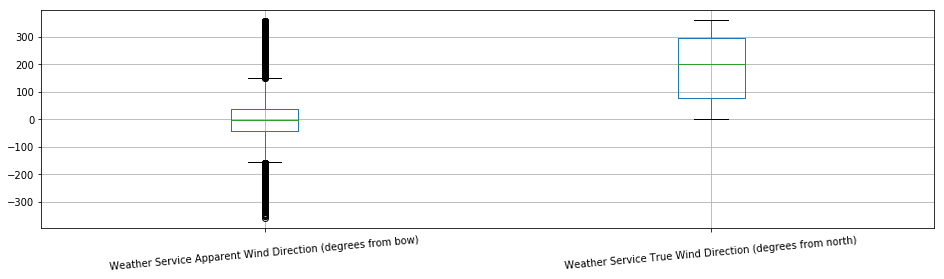

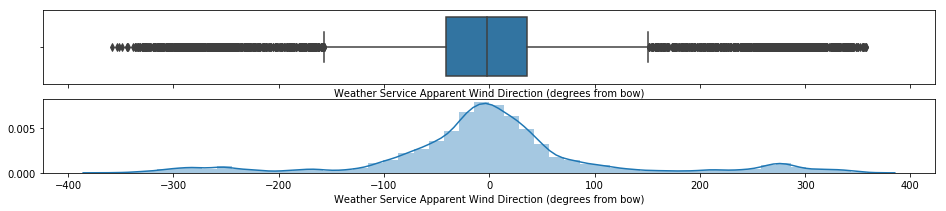

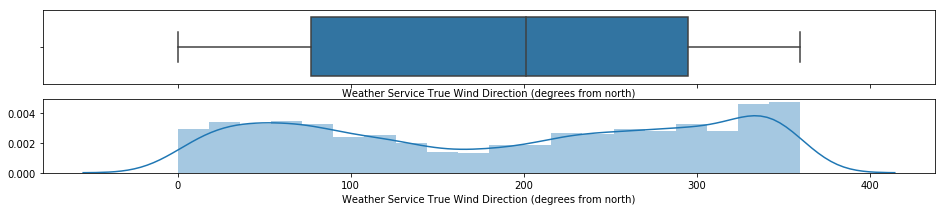

In [36]:
# Wind direction
plt.figure("Boxplot", figsize=(16,4))
df_mod[[cols_wind[1],cols_wind[3]]].boxplot()
plt.xticks(rotation=5)

# Apparent wind direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[1]], ax=ax_box)
sns.distplot(df_mod[cols_wind[1]], ax=ax_hist)

# True wind direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[3]], ax=ax_box)
sns.distplot(df_mod[cols_wind[3]], ax=ax_hist)

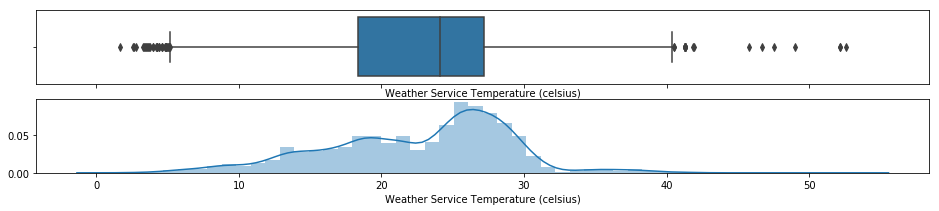

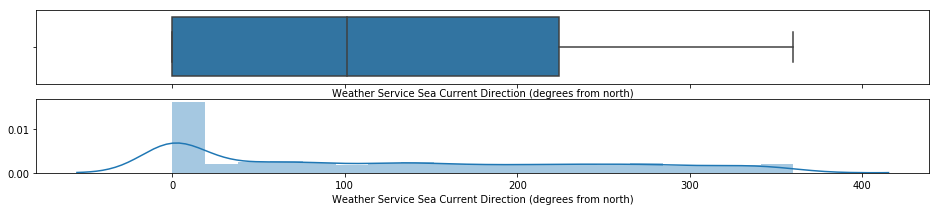

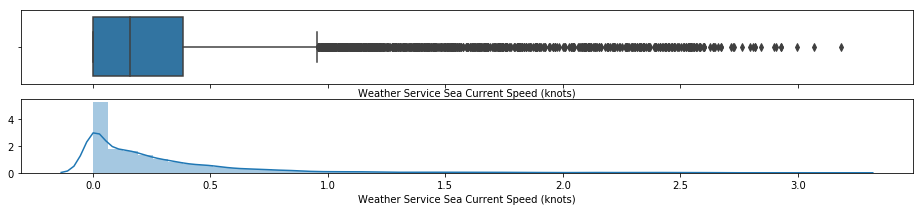

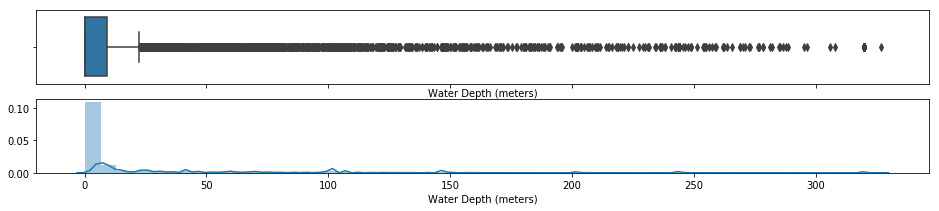

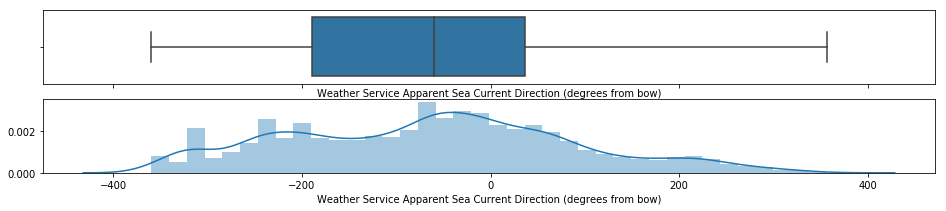

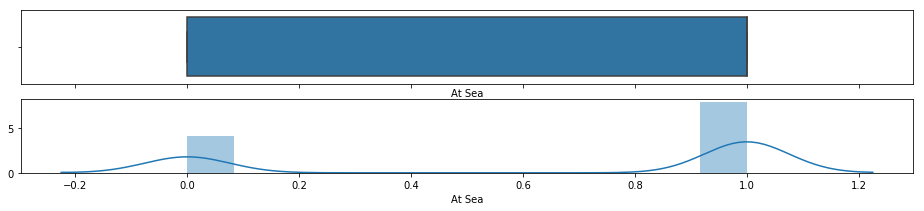

In [37]:
# Sea temperature
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[0]], ax=ax_box)
sns.distplot(df_mod[cols_sea[0]], ax=ax_hist)

# Sea current direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[1]], ax=ax_box)
sns.distplot(df_mod[cols_sea[1]], ax=ax_hist)

# Sea current speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[2]], ax=ax_box)
sns.distplot(df_mod[cols_sea[2]], ax=ax_hist)

# Sea water depth
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[3]], ax=ax_box)
sns.distplot(df_mod[cols_sea[3]], ax=ax_hist)

# Apparent sea current direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Weather Service Apparent Sea Current Direction (degrees from bow)'], ax=ax_box)
sns.distplot(df_mod['Weather Service Apparent Sea Current Direction (degrees from bow)'], ax=ax_hist)

# At sea
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['At Sea'], ax=ax_box)
sns.distplot(df_mod['At Sea'], ax=ax_hist)

# Feature Selection

In [38]:
df_mod.columns

Index(['Time', 'Main Engine Fuel Consumption (MT/day)',
       'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)',
       'Draft Forward (meters)', 'Draft Aft (meters)', 'Draft Mid-1 (meters)',
       'Draft Mid-2 (meters)', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)', 'Speed Over Ground (knots)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service True Wind Speed (knots)',
       'Weather Service True Wind Direction (degrees from north)',
       'Weather Service Temperature (celsius)',
       'Weather Service Sea Current Direction (degrees from north)',
       'Weather Service Sea Current Speed (knots)', 'Water Depth (meters)',
       'Draft Mean (meters)', 'Trim (meters)', 'List (meters)',
       'Weather Service Apparent Sea Current Direction (degrees from bow)',
      

In [51]:
df_feat = df_mod[['Main Engine Fuel Consumption (MT/day)',
                  'Main Engine Using MGO (bool)',
                  'Shaft Speed (RPM)',
                  'Shaft Torque (kNm)',
                  'Shaft Power (kW)',
                  'Speed Over Ground (knots)',
                  'Speed Through Water (knots)',
                  'Heading (degrees)',
                  'Rudder Angle (degrees)',
                  'Weather Service Apparent Wind Speed (knots)',
                  'Weather Service Apparent Wind Direction (degrees from bow)',
                  'Weather Service True Wind Speed (knots)',
                  'Weather Service True Wind Direction (degrees from north)',
                  'Weather Service Temperature (celsius)',
                  'Weather Service Sea Current Direction (degrees from north)',
                  'Weather Service Sea Current Speed (knots)',
                  'Water Depth (meters)',
                  'Draft Mean (meters)',
                  'Trim (meters)',
                  'List (meters)',
                  'Weather Service Apparent Sea Current Direction (degrees from bow)',
                  'At Sea']]

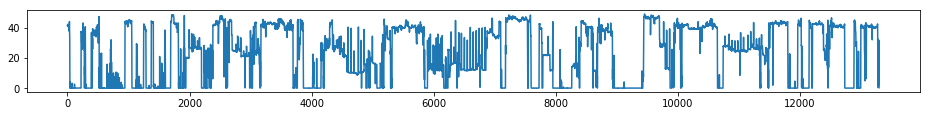

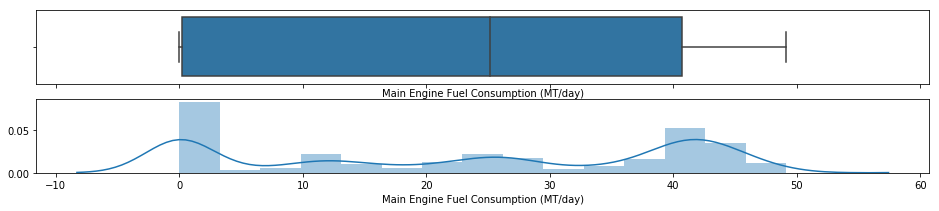

In [52]:
# Main engine fuel consumption
feat = 'Main Engine Fuel Consumption (MT/day)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

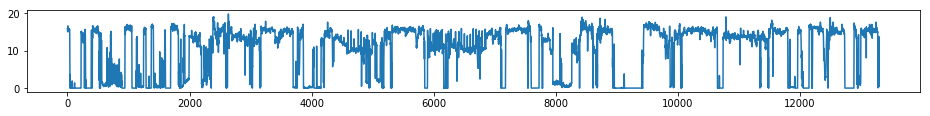

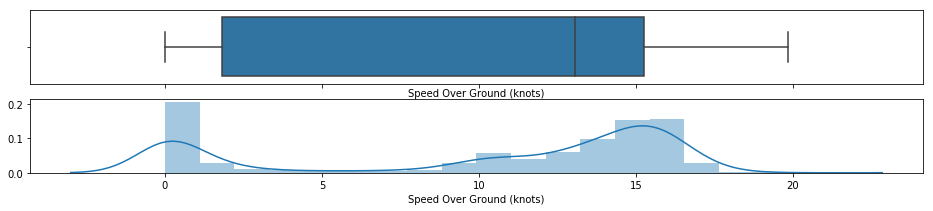

In [41]:
# Speed over ground
feat = 'Speed Over Ground (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

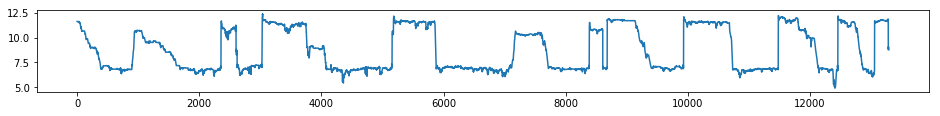

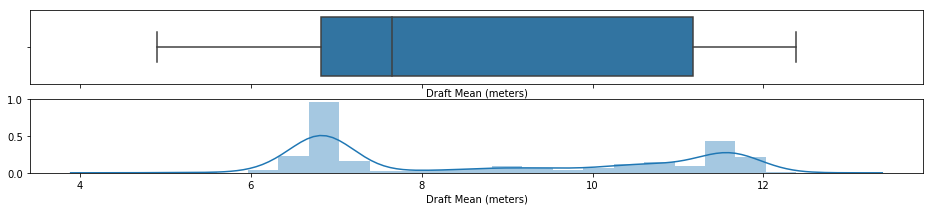

In [42]:
# Draft mean
feat = 'Draft Mean (meters)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

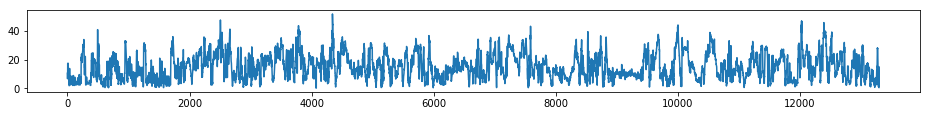

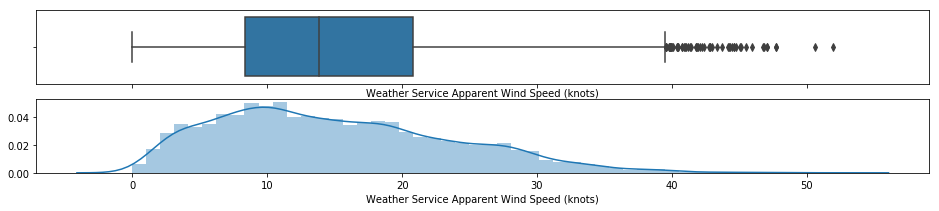

In [43]:
# Apparent wind speed
feat = 'Weather Service Apparent Wind Speed (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

# Regression Model

In [77]:
# Set target and feature variables
y = df_feat[     'Main Engine Fuel Consumption (MT/day)']
X = df_feat.drop('Main Engine Fuel Consumption (MT/day)',axis=1)

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(10635, 21)
(2659, 21)


In [78]:
# Train regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

features                = pd.DataFrame(X.columns.T, columns=['Feature'])
features['Coefficient'] = reg.coef_.T
features                = features.append({'Feature': 'Intercept','Coefficient': reg.intercept_}, ignore_index=True)
features                = features.set_index('Feature')
features                = features.merge(pd.DataFrame(X_train.min(),columns=['Min Limit']),
                                         left_index=True,right_index=True,how='left')
features                = features.merge(pd.DataFrame(X_train.max(),columns=['Max Limit']),
                                         left_index=True,right_index=True,how='left')
features['Min Effect']  = features['Coefficient'] * features['Min Limit']
features['Max Effect']  = features['Coefficient'] * features['Max Limit']
features.sort_values(by='Coefficient',ascending=False)

Coefficient   Min Limit  \
Feature                                                                       
At Sea                                                 0.576651    0.000000   
Trim (meters)                                          0.245281   -0.547380   
Main Engine Using MGO (bool)                           0.203667    0.000000   
Speed Over Ground (knots)                              0.111445    0.000000   
Draft Mean (meters)                                    0.093098    4.898437   
Weather Service Apparent Wind Speed (knots)            0.018647    0.000000   
Weather Service True Wind Speed (knots)                0.009773    0.000000   
Water Depth (meters)                                   0.008907    0.000000   
Rudder Angle (degrees)                                 0.007519  -37.916252   
Shaft Power (kW)                                       0.004170    5.302457   
Shaft Speed (RPM)                                      0.002551   -7.110332   
Weather Service Sea Current Direction (degrees ...     0.000202    0.000000   
Heading (degrees)                                      0.000183    0.158951   
Weather Service Apparent Sea Current Direction ...     0.000019 -359.824424   
Shaft Torque (kNm)                                    -0.000131   -0.000460   
Weather Service True Wind Direction (degrees fr...    -0.000480    0.000568   
Weather Service Apparent Wind Direction (degree...    -0.001136 -358.561592   
Weather Service Temperature (celsius)                 -0.014389    1.646941   
Speed Through Water (knots)                           -0.042008   -0.812132   
List (meters)                                         -0.111125   -0.985489   
Weather Service Sea Current Speed (knots)             -0.269422    0.000000   
Intercept                                             -0.971620         NaN   

                                                       Max Limit  \
Feature                                                            
At Sea                                                  1.000000   
Trim (meters)                                           5.511462   
Main Engine Using MGO (bool)                            1.000000   
Speed Over Ground (knots)                              19.844884   
Draft Mean (meters)                                    12.385497   
Weather Service Apparent Wind Speed (knots)            47.723142   
Weather Service True Wind Speed (knots)                40.416629   
Water Depth (meters)                                  320.000000   
Rudder Angle (degrees)                                 36.801810   
Shaft Power (kW)                                    11150.041983   
Shaft Speed (RPM)                                      88.959431   
Weather Service Sea Current Direction (degrees ...    359.999716   
Heading (degrees)                                     359.824424   
Weather Service Apparent Sea Current Direction ...    356.451090   
Shaft Torque (kNm)                                   1206.076706   
Weather Service True Wind Direction (degrees fr...    359.997076   
Weather Service Apparent Wind Direction (degree...    358.000339   
Weather Service Temperature (celsius)                  52.559168   
Speed Through Water (knots)                            17.186902   
List (meters)                                           1.252011   
Weather Service Sea Current Speed (knots)               3.184603   
Intercept                                                    NaN   

                                                      Min Effect  Max Effect  
Feature                                                                       
At Sea                                              0.000000e+00    0.576651  
Trim (meters)                                      -1.342620e-01    1.351858  
Main Engine Using MGO (bool)                        0.000000e+00    0.203667  
Speed Over Ground (knots)                           0.000000e+00    2.211610  
Draft Mean (meters)                             

R-squared score:         0.995
Root mean squared error: 1.275


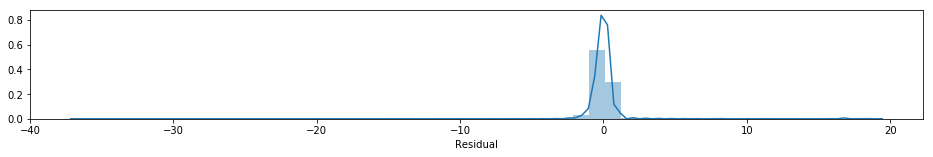

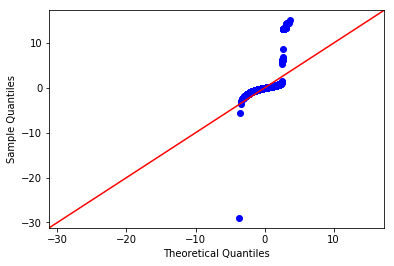

In [79]:
# Predictions of training set
y_train_pred = reg.predict(X_train)
print('R-squared score:         %.3f' % r2_score(y_train,  y_train_pred))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_train,  y_train_pred)))

# Residuals of training set
X_train['Residual'] = y_train - y_train_pred

# Plot distributions of residuals
plt.subplots(figsize=(16,2))
sns.distplot(X_train['Residual'])

# Examine normality of residuals
fig = sm.graphics.qqplot(X_train['Residual'], dist=stats.norm, line='45', fit=True)
fig.show()

In [105]:
# Investigate regression outliers
reg_outliers               = X_train.copy()
reg_outliers[cols_main[1]] = y_train
reg_outliers['Prediction'] = y_train_pred
reg_outliers               = reg_outliers[
    (reg_outliers['Residual'] >  np.sqrt(mean_squared_error(y_train,  y_train_pred))) |
    (reg_outliers['Residual'] < -np.sqrt(mean_squared_error(y_train,  y_train_pred)))]
print(reg_outliers.shape)
reg_outliers.sort_values(by='Residual',ascending=False).head()

(325, 24)


Main Engine Using MGO (bool)  Shaft Speed (RPM)  Shaft Torque (kNm)  \
1992                             0          35.212202          356.306213   
1990                             0           0.000000            3.444813   
1987                             0           0.000000            3.759159   
1986                             0           0.000000            3.539458   
1988                             0           0.000000            5.998027   

      Shaft Power (kW)  Speed Over Ground (knots)  \
1992       2231.594533                   6.727125   
1990          5.984311                   2.227363   
1987          5.984367                   2.286703   
1986          5.993809                   2.310131   
1988          5.999985                   2.369297   

      Speed Through Water (knots)  Heading (degrees)  Rudder Angle (degrees)  \
1992                     6.333909         282.869466               -0.973671   
1990                     1.554693         281.306291               -0.746288   
1987                     1.567764         277.699371               -0.818222   
1986                     1.587873         281.702058               -0.813141   
1988                     1.625501         279.580680               -0.811172   

      Weather Service Apparent Wind Speed (knots)  \
1992                                    17.490167   
1990                                    17.715045   
1987                                    18.898268   
1986                                    19.066108   
1988                                    18.907930   

      Weather Service Apparent Wind Direction (degrees from bow)     ...      \
1992                                        -274.746775              ...       
1990                                        -258.351755              ...       
1987                                        -249.513613              ...       
1986                                        -253.739674              ...       
1988                                        -251.740366              ...       

      Weather Service Sea Current Speed (knots)  Water Depth (meters)  \
1992                                   0.236598                   0.0   
1990                                   0.207423                   0.0   
1987                                   0.189004                   0.0   
1986                                   0.193018                   0.0   
1988                                   0.191299                   0.0   

      Draft Mean (meters)  Trim (meters)  List (meters)  \
1992             6.552312       2.428030      -0.187717   
1990             6.503359       2.238417      -0.179427   
1987             6.472534       2.248158      -0.131102   
1986             6.463121       2.275092      -0.137619   
1988             6.505204       2.227284      -0.173121   

      Weather Service Apparent Sea Current Direction (degrees from bow)  \
1992                                          71.850795                   
1990                                        -276.952713                   
1987                                        -250.396447                   
1986                                        -247.372017                   
1988                                        -261.587379                   

      At Sea   Residual  Main Engine Fuel Consumption (MT/day)  Prediction  
1992       1  19.237984                              30.437220   11.199237  
1990       1  18.463056                              19.904283    1.441227  
1987       1  18.422471                              19.898726    1.476255  
1986       1  18.389132                              19.883147    1.494016  
1988       1  18.376345                              19.861599    1.485254  

[5 rows x 24 columns]

In [106]:
reg_outliers.sort_values(by='Residual').head()

Main Engine Using MGO (bool)  Shaft Speed (RPM)  Shaft Torque (kNm)  \
13061                             0          86.480941         1060.864629   
13059                             1          68.622969          654.640221   
13272                             1          74.381197          826.313097   
8735                              1          81.650550          945.559722   
8584                              0          75.570828          796.167532   

       Shaft Power (kW)  Speed Over Ground (knots)  \
13061       9631.164310                  16.015521   
13059       4737.562993                  15.225742   
13272       6464.559545                  12.737318   
8735        8164.167594                  16.481692   
8584        6328.639664                  14.321479   

       Speed Through Water (knots)  Heading (degrees)  Rudder Angle (degrees)  \
13061                    15.384141         107.006778               -3.392840   
13059                    13.276921          55.950016               -1.070987   
13272                    12.969777          16.373877               -3.329781   
8735                     14.898203         240.972999               -2.674047   
8584                     14.277028          94.172671               -3.292074   

       Weather Service Apparent Wind Speed (knots)  \
13061                                     5.333103   
13059                                     6.169390   
13272                                    23.396645   
8735                                     28.006546   
8584                                     17.083619   

       Weather Service Apparent Wind Direction (degrees from bow)     ...      \
13061                                          40.807797              ...       
13059                                          73.846738              ...       
13272                                          13.756534              ...       
8735                                           -5.692415              ...       
8584                                           42.233864              ...       

       Weather Service Sea Current Speed (knots)  Water Depth (meters)  \
13061                                   0.221062              0.000000   
13059                                   0.211821             85.346769   
13272                                   0.164544             53.676343   
8735                                    0.071826             86.506137   
8584                                    0.074580             92.336058   

       Draft Mean (meters)  Trim (meters)  List (meters)  \
13061            11.702409       0.388791      -0.267385   
13059             6.655877       2.242140       0.325462   
13272            11.683708       0.138903       0.055926   
8735             11.781332       0.470423       0.069327   
8584             10.779540       1.007457      -0.273837   

       Weather Service Apparent Sea Current Direction (degrees from bow)  \
13061                                          53.455950                   
13059                                         124.049984                   
13272                                         224.576153                   
8735                                          -91.245930                   
8584                                          -78.697110                   

       At Sea   Residual  Main Engine Fuel Consumption (MT/day)  Prediction  
13061       1 -36.954614                               4.814650   41.769264  
13059       0  -7.123092                              14.902984   22.026075  
13272       0  -4.692461                              24.158124   28.850586  
8735        0  -3.682420                              33.177889   36.860308  
8584        0  -3.229652                              25.360158   28.589811  

[5 rows x 24 columns]

In [107]:
reg_outliers.describe()

Main Engine Using MGO (bool)  Shaft Speed (RPM)  Shaft Torque (kNm)  \
count                    325.000000         325.000000          325.000000   
mean                       0.160000          38.379221          442.936410   
std                        0.367171          36.028952          434.614708   
min                        0.000000           0.000000            0.868353   
25%                        0.000000           0.000000            5.545407   
50%                        0.000000          41.163238          329.245346   
75%                        0.000000          74.029635          894.466479   
max                        1.000000          87.638010         1161.837532   

       Shaft Power (kW)  Speed Over Ground (knots)  \
count        325.000000                 325.000000   
mean        3480.440376                   7.394606   
std         3734.573745                   5.999553   
min            5.961061                   0.068179   
25%            6.179815                   1.932478   
50%         1653.356164                   5.654757   
75%         6784.624350                  13.944376   
max        10315.525310                  19.057311   

       Speed Through Water (knots)  Heading (degrees)  Rudder Angle (degrees)  \
count                   325.000000         325.000000              325.000000   
mean                      7.111693         212.301021               -1.276877   
std                       6.179622          89.179035                4.276614   
min                      -0.450795           0.910649              -24.495344   
25%                       1.136350         141.372369               -2.322567   
50%                       5.516023         247.911472               -1.135842   
75%                      13.730402         279.961604               -0.694907   
max                      16.578963         359.343520               30.801655   

       Weather Service Apparent Wind Speed (knots)  \
count                                   325.000000   
mean                                     17.739435   
std                                       9.262273   
min                                       0.880910   
25%                                      11.260413   
50%                                      17.543826   
75%                                      21.642552   
max                                      43.737196   

       Weather Service Apparent Wind Direction (degrees from bow)     ...      \
count                                         325.000000              ...       
mean                                          -40.374320              ...       
std                                           145.202820              ...       
min                                          -328.435894              ...       
25%                                          -109.899732              ...       
50%                                             3.450344              ...       
75%                                            40.844577              ...       
max                                           358.000339              ...       

       Weather Service Sea Current Speed (knots)  Water Depth (meters)  \
count                                 325.000000            325.000000   
mean                                    0.240327            149.657526   
std                                     0.459458            122.795857   
min                                     0.000000              0.000000   
25%                                     0.000000              9.779642   
50%                                     0.047180            177.601088   
75%                                     0.195273            244.000000   
max                                     2.928559            320.000000   

       Draft Mean (meters)  Trim (meters)  List (meters)  \
count           325.000000     325.000000     325.000000   
mean              8.277622       1.745359      -0.047388   
std               2.003

In [108]:
df_feat.describe()

Main Engine Fuel Consumption (MT/day)  Main Engine Using MGO (bool)  \
count                           13294.000000                  13294.000000   
mean                               23.088197                      0.062058   
std                                17.431775                      0.241270   
min                                 0.000000                      0.000000   
25%                                 0.201277                      0.000000   
50%                                25.125368                      0.000000   
75%                                40.672698                      0.000000   
max                                49.138823                      1.000000   

       Shaft Speed (RPM)  Shaft Torque (kNm)  Shaft Power (kW)  \
count       13294.000000        13294.000000      13294.000000   
mean           54.767804          621.972953       5179.079963   
std            35.363715          435.562025       4004.406412   
min            -7.110332           -0.000460          5.276229   
25%             0.000000           12.027868          7.960926   
50%            71.773562          745.846497       5630.125342   
75%            85.696325         1038.392816       9315.960332   
max            88.959431         1206.091541      11150.041983   

       Speed Over Ground (knots)  Speed Through Water (knots)  \
count               13294.000000                 13294.000000   
mean                   10.055001                     9.953996   
std                     6.314415                     6.320701   
min                     0.000000                    -0.812132   
25%                     1.807973                     1.325097   
50%                    13.044746                    13.059407   
75%                    15.263638                    15.232244   
max                    19.844884                    17.186902   

       Heading (degrees)  Rudder Angle (degrees)  \
count       13294.000000            13294.000000   
mean          189.708437               -1.254819   
std           101.726415                3.393461   
min             0.123706              -37.916252   
25%            90.143655               -2.054992   
50%           225.322315               -1.242882   
75%           277.797905               -0.682076   
max           359.824424               36.801810   

       Weather Service Apparent Wind Speed (knots)      ...       \
count                                 13294.000000      ...        
mean                                     15.038842      ...        
std                                       8.649540      ...        
min                                       0.000000      ...        
25%                                       8.314335      ...        
50%                                      13.822674      ...        
75%                                      20.802552      ...        
max                                      51.955335      ...        

       Weather Service True Wind Direction (degrees from north)  \
count                                       13294.000000          
mean                                          188.159086          
std                                           114.740370          
min                                             0.000568          
25%                                            77.182397          
50%                                           201.647541          
75%                                           295.228736          
max                                           359.997076          

       Weather Service Temperature (celsius)  \
count                           13294.000000   
mean                               22.597054   
std                                 6.345735   
min                                 1.646941   
25%                                18.369530   
50%                                24.121217   
75%                                27.173381   
max                                52.559168   

    

<Figure size 432x216 with 0 Axes>

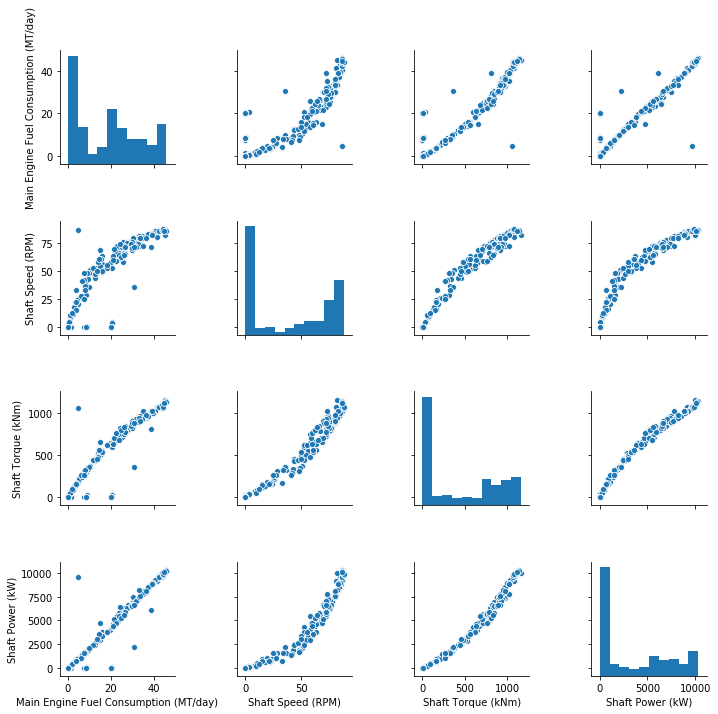

In [104]:
# Pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_shaft)
sns.pairplot(reg_outliers[cols])

R-squared score:         0.993
Root mean squared error: 1.463


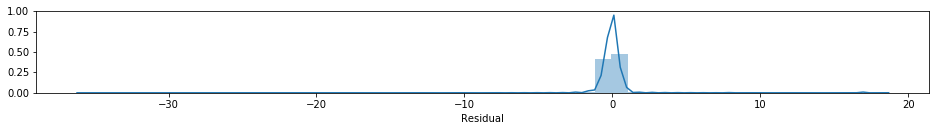

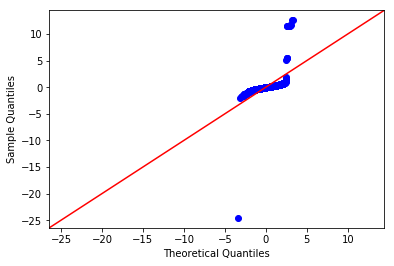

In [80]:
# Predictions of test set
y_test_pred = reg.predict(X_test)
print('R-squared score:         %.3f' % r2_score(y_test,  y_test_pred))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test,  y_test_pred)))

# Residuals of test set
X_test['Residual'] = y_test - y_test_pred

# Plot distributions of residuals
plt.subplots(figsize=(16,1.5))
sns.distplot(X_test['Residual'])

# Examine normality of residuals
fig = sm.graphics.qqplot(X_test['Residual'], dist=stats.norm, line='45', fit=True)
fig.show()

# Speed Scores

# Sensor Drift